# Crypto Trading Environment
### Overview
A reinforcement learning environment for trading crypto pairs. This environment is targeted at trading a single pair. In future iterations of this environment, we will explore allowing the trading of multiple pairs on the same environment.
### Features
- Allows for features / indicators / additional numerical data in the observation space.
- Memory allows for the current timestep's observation space to have X length of historical data most recent to the current timestep.
- Long-only positions as this is common in the crypto-world.
- When buying stakes, max_stake_count of stakes are allowed however when selling, the environment sells all stakes at once.
### References
|Reference|Relevance|
|--|--|
|[OpenAI Gym Base](https://github.com/openai/gym/blob/master/gym/core.py)|The base class for our environment. This interface seems to be a standard in the reinforcement learning space.|
|[AnyTrading Foundation](https://github.com/AminHP/gym-anytrading)|We used AnyTrading's work as a reference point for creating our own environment that's a little more talored to our needs.|

### Import Dependencies

In [ ]:
from enum import Enum
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython import display
import time

%matplotlib inline

import os
from tensorforce import Agent, Environment

### Import Data
We use the lab we worked on before for market_trading > parse_market_data to get the latest market information from FrostAura Plutus.

In [228]:
model_file_path = './data/featurized_market_data.p'

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

#### Split Data
- Price Movement Data
  - Time
  - Open
  - Close
  - High
  - Low
  - Volume
- Feature Data
  - Indicators 
  - Features
  - Balances
  - Stakes 

In [229]:
pair_name = 'AAVE_BTC'
pair_data = featurized_market_data[pair_name]

# This dataset contains open, close, high, low, volume and any numerical features / indicators you like.
price_movement_df = pair_data

### Action Space
This refers to the decisions / actions that can be applied to the environment. Usually decided by some intelligent system like a neural network or a state vector machine.

In [230]:
class Actions(Enum):
    Hold = 0
    Buy = 1
    Sell = 2

### Price Movement
This refers to the columns we can expect to be present always in the data. Open, close, high, low, volume and time.

In [231]:
class PriceMovementColumns(Enum):
    Time = 'time'
    Open = 'open'
    High = 'high'
    Low = 'low'
    Close = 'close'
    Volume = 'volume'

### Transactions
This refers to all the columns that we can expect to see in the transactions dataframe. This allows us to track all buys and sells over time. This dataframe is append-only and so we resort to joins to determine open transactions. This helps us in the long run to visualize performance and extend the enviroment's behavior. 

In [232]:
class TransactionsColumns(Enum):
    PairName = 'pair_name'
    Time = 'time_of_transaction'
    Price = 'price_at_transaction_time'
    Quantity = 'quantity'
    IsBuy = 'is_buy_order'

### Environment Internal Observations
These observations are appended to the data provided to the environment as to keep track of the environment's internal state and expose that to any wrapping model.

In [233]:
class InternalColumns(Enum):
    OpenTransactionCount = '__open_transaction_count__'

### Define the Environment

In [234]:
class CryptoTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, data, pair_name, max_stake_count=1, memory_window_size=50, seed=None, trading_fee_percentage=0.001):
        assert data.ndim == 2, 'The price movement & features dataframe can only be an array of 2 dimensions (tabular).'
        assert max_stake_count > 0, 'The max allowed stake units should be 1 or more. This allows for position stacking on a given pair. Stake amount for the first transaction would implicitly be total_profit/max_stake_count.'
        assert memory_window_size > 0, 'The memory window should be 1 for no memory (only the most recent 1) or a positive number for a length of historical events to keep.'
        assert data.shape[0] > memory_window_size, 'The provided data has to contain at least as many records as the length of the memory window.'
        assert trading_fee_percentage > 0 and trading_fee_percentage < 1, 'A valid trading fee is required. Usually around 0.003 (0.3%).'
        
        self.seed(seed)
        
        # Persist locals.
        self.pair_name = pair_name
        self.data = self.__extend_data_columns_and_default_values__(data.fillna(0))
        self.max_stake_count = max_stake_count
        self.memory_window_size = memory_window_size
        self.trading_fee_percentage = trading_fee_percentage
        self.memory_shape = (self.memory_window_size, self.data.drop(PriceMovementColumns.Time.value, axis=1).shape[1])
        
        # Define spaces. This can be thought of the input and output of any model we build around this environment.
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.memory_shape, dtype=np.float32)
        
        self.reset()

    def __extend_data_columns_and_default_values__(self, df):
        result = df.copy()
        
        for internal_column in InternalColumns:
            result[internal_column.value] = 0
        
        return result
    
    def __take_action__(self, action):
        current_timestep = self.current_window[-1:]
        open_transactions = self.__get_open_transactions__()
        open_transactions_count = open_transactions.shape[0]
        penalty_for_invalid_transaction = 0
        
        if Actions(action) == Actions.Buy:
            # Only allow for max_stake_count purchases.
            positions_left_to_buy = self.max_stake_count - open_transactions_count
            
            if positions_left_to_buy > 0:
                # Determine the quantity for a stake given how many stakes are still available.
                stake_amount = self.balance / positions_left_to_buy
                
                # Make purchase.
                self.transactions = self.transactions.append({
                    TransactionsColumns.PairName.value: self.pair_name,
                    TransactionsColumns.Time.value: current_timestep[PriceMovementColumns.Time.value].values[0],
                    TransactionsColumns.Price.value: current_timestep[PriceMovementColumns.Close.value].values[0],
                    TransactionsColumns.Quantity.value: stake_amount,
                    TransactionsColumns.IsBuy.value: True
                }, ignore_index=True)
                # Adjust base pair balance.
                self.balance -= stake_amount
                
                # Reward for taking an action.
                penalty_for_invalid_transaction += 1
            else:
                # If a buy is attempted but there are no more allowed transactions, penalize the action. # TODO: Experiment with this. Lower the penalty. Take it away. Etc.
                penalty_for_invalid_transaction =- 1
        
        if Actions(action) == Actions.Sell:
            # Only sell when we have any open transactions.
            if open_transactions_count > 0:
                current_price = current_timestep[PriceMovementColumns.Close.value].values[0]
                
                # Sell all transactions at once.
                for index, row in open_transactions.iterrows():
                    quantity = row[TransactionsColumns.Quantity.value]
                    
                    # Calculate the profit for the respective transaction and add it to the running profit in the environment.
                    self.balance += current_price * quantity
                    # Make sell.
                    self.transactions = self.transactions.append({
                        TransactionsColumns.PairName.value: self.pair_name,
                        TransactionsColumns.Time.value: current_timestep[PriceMovementColumns.Time.value].values[0],
                        TransactionsColumns.Price.value: current_timestep[PriceMovementColumns.Close.value].values[0],
                        TransactionsColumns.Quantity.value: quantity,
                        TransactionsColumns.IsBuy.value: False
                    }, ignore_index=True)
                
                # Reward for taking an action.
                penalty_for_invalid_transaction += 1
            else:
                # If a sell is attempted but there are no open transactions, penalize the action.
                penalty_for_invalid_transaction =- 1
        
        # Refresh open transactions after altering them.
        if Actions(action) == Actions.Hold:
            # If a sell is attempted but there are no open transactions, penalize the action.
            penalty_for_invalid_transaction =- 0.1
        else:
            open_transactions = self.__get_open_transactions__()
        
        # On a hold, we simply return the rewards without changing the purchases data.
        return (self.__determine_reward__(open_transactions) + penalty_for_invalid_transaction), open_transactions
    
    def __determine_reward__(self, open_transactions):
        # Determine the reward for the balance (-1 that we started with).
        balance_reward = self.balance - 1
        
        # Offset that balance by the profits of open transactions.
        open_transactions_profits_reward = 0
        current_price = self.current_window[-1:][PriceMovementColumns.Close.value].values[0]
        
        for index, open_transaction in open_transactions.iterrows():
            ot_buy_price = open_transaction[TransactionsColumns.Price.value]
            ot_qty = open_transaction[TransactionsColumns.Quantity.value]
            # Calculate the different in price from when we purchased it. Multiply by how much we have to get total profit. Divide by allowed parallel transactions to normalize the reward cross-configuration.
            ot_profit = ((current_price - ot_buy_price) * ot_qty / self.max_stake_count)
            open_transactions_profits_reward += ot_profit
            
        open_transactions_profits_reward *= 10000
        
        # Update the episode's total running reward.
        reward = balance_reward + open_transactions_profits_reward
        self.total_reward += reward
        
        return reward
    
    def __determine_observation__(self, open_transactions):
        # Update the stakes on the most recent record / last record in the current window.
        # Configure internal features.
        stakes_open = open_transactions.shape[0]
        # Perform the update on the entire dataframe as well as the current window.
        #self.data.at[self.current_window_end_index, InternalColumns.OpenTransactionCount.value] = stakes_open
        #self.current_window.at[self.current_window.shape[0] - 2, InternalColumns.OpenTransactionCount.value] = stakes_open
        
        result = self.current_window.drop(PriceMovementColumns.Time.value, axis=1)

        assert result.shape == self.observation_space.shape, f'[STEP {self.current_step}]: The shape of the current observation {result.shape} is different from the observation_space shape {self.observation_space.shape}.'

        return result.to_numpy()
    
    def __determine_done__(self, open_transactions):
        if self.current_window.shape[0] < self.memory_window_size:
            print('Ran out of time. Environment is now done.')
            return True

        open_transaction_count = open_transactions.shape[0]
        
        if self.balance <= 0 and open_transaction_count <= 0:
            print(f'Ran out of capital with {open_transaction_count} remaining open transactions. Environment is now done.')
            return True
            
        return False
    
    def __get_step_info__(self, open_transactions):
        return dict(
            total_reward = self.total_reward,
            balance = self.balance,
            open_transactions = open_transactions
        )
        
    def __next_timestep__(self):
        self.current_window_start_index += 1
        self.current_window_end_index += 1
        self.current_window = self.data[self.current_window_start_index:self.current_window_end_index]
    
    def __get_open_transactions__(self):
        all_transactions = self.transactions
        sell_transaction_indexes = all_transactions.index[all_transactions[TransactionsColumns.IsBuy.value] == False]
        last_sold_transaction_index = sell_transaction_indexes[-1] if len(sell_transaction_indexes) > 0 else -1
        first_open_transaction_index = last_sold_transaction_index + 1
        open_transactions = all_transactions[first_open_transaction_index:]

        return open_transactions
    
    def step(self, action):
        self.current_step += 1
        step_reward, open_transactions = self.__take_action__(action)
        observation = self.__determine_observation__(open_transactions)
        info = self.__get_step_info__(open_transactions)
        
        self.__next_timestep__()
        
        done = self.__determine_done__(open_transactions)
        
        return observation, step_reward, done, info
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        
        return [seed]

    def reset(self):
        self.current_step = 0
        self.data = self.__extend_data_columns_and_default_values__(self.data)
        self.current_window_start_index = 0
        self.current_window_end_index = self.memory_window_size
        self.current_window = self.data[self.current_window_start_index:self.current_window_end_index]
        self.total_reward = 0.
        self.balance = 1.
        self.transactions = pd.DataFrame(columns=[ ck.value for ck in TransactionsColumns ])

        return self.current_window.drop(PriceMovementColumns.Time.value, axis=1).to_numpy()

    def render(self, mode='human'):
        assert mode == 'human', 'Currently only human-mode is supported for rendering with rgb_array support coming.'
        
        print(f'Rendering the environment results now. {self.data.shape[0]} close price points and {self.transactions.shape[0]} transaction points. This may take a while.')
        plt.cla()
        plt.plot(self.data[PriceMovementColumns.Time.value], self.data[PriceMovementColumns.Close.value])
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        
        # Draw an indicator for all transactions.
        for index, transaction in self.transactions.iterrows():
            color = 'green' if transaction[TransactionsColumns.IsBuy.value] == True else 'red'
            tick = transaction[TransactionsColumns.Time.value]
            close = transaction[TransactionsColumns.Price.value]
            plt.scatter(tick, close, color=color)
            
        # If the account was depleted, render an indicator for when that happened.
        if self.balance <= 0.0:
            last_transaction = self.transactions[-1:]
            last_transaction_time = last_transaction[TransactionsColumns.Time.value].values[0]
            last_transaction_price = last_transaction[TransactionsColumns.Price.value].values[0]
            plt.axvline(last_transaction_time, last_transaction_price, color='red')
        
        plt.title(self.pair_name)
        plt.suptitle(
            f'Total Reward: {self.total_reward} ~ Total Profit: {round((self.balance - 1) * 100, 2)}% ~ Steps: {self.current_window_start_index + 1}'
        )

In [235]:
env = CryptoTradingEnv(pair_data, pair_name)

### Assertions
A few basic tests to assure the environment is still behaving as expected.

In [236]:
assert env.current_window.copy().drop(PriceMovementColumns.Time.value, axis=1).shape == env.observation_space.shape, f'The observation space "{env.observation_space.shape}" should be the same size as the window of historical observations "{env.current_window.shape}".'
assert env.transactions.shape[1] == len(TransactionsColumns) + len(InternalColumns) - 1, 'The auto-generated transactions dataframe should have all columns from the transactions columns enum.'
assert env.reset().shape == env.observation_space.shape, f'The observation_space shape has changed after the reset. This is not allowed.'

### End-to-end Random Agent Result
We take a bunch of random actions until the time or capital runs out and render the results.

In [237]:
# Visualization Utility
def visualize_episodes(rewards, transaction_counts, balances):
    # Visualization
    plt.figure()
    plt.xlabel('Episode')
    
    # Balances
    plt.plot(balances)
    
    # Rewards
    plt.plot(rewards)
    
    # Transaction Counts
    plt.plot(transaction_counts)
    
    plt.legend(['Balance', 'Reward', 'Actions'], loc ='upper left')
    display.clear_output(wait=True)
    display.display(plt.gcf())

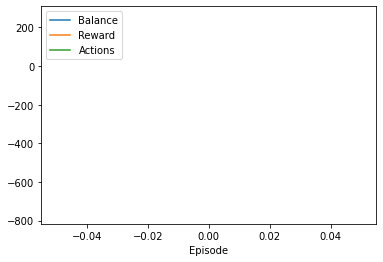

Episode 1/1 Reward: -765.2002245753613. Balance: 0.0. Transaction Count: 258


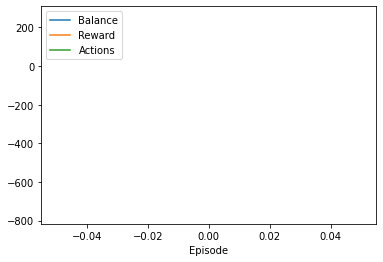

In [238]:
# Episode diagnostics.
episode_count = 1
episode_rewards = []
episode_transaction_count = []
episode_balances = []

env = CryptoTradingEnv(pair_data, pair_name, max_stake_count=1, memory_window_size=24)

for ei in range(episode_count):
    done = False
    states = env.reset()
    step = 0
    
    while not done:
        step += 1
        action = env.action_space.sample()
        states, reward, done, info = env.step(action)

    episode_rewards.append(env.total_reward)
    episode_transaction_count.append(env.transactions.shape[0])
    episode_balances.append(env.balance)
    
    visualize_episodes(episode_rewards, episode_transaction_count, episode_balances)
    print(f'Episode {ei + 1}/{episode_count} Reward: {env.total_reward}. Balance: {env.balance}. Transaction Count: {env.transactions.shape[0]}')

### Journey to an Intelligent Agent

#### Tensorforce

##### Create Agent

In [239]:
def create_tensorforce_agent(env_name, gym_environment, model_path='./data/models/tf.{}.{}.tensorforce', force_create=False):
    normalized_path = model_path.format(env_name.lower(), env_name.lower().replace(' ','_'))
    environment = Environment.create(environment=gym_environment)
    does_model_exist = os.path.exists(normalized_path)
    agent = None
    
    if does_model_exist and not force_create:
        print(f'Loading existing model.')
        agent = Agent.load(directory=normalized_path, format='checkpoint', environment=environment)
    else:
        print(f'No directory "{normalized_path}" exists. Creating a new model.')

        agent = Agent.create(
            saver=dict(
                directory=normalized_path,
                frequency=50,
                max_checkpoints=5
            ),
            agent='tensorforce', 
            environment=environment, 
            update=64,
            optimizer=dict(optimizer='adam', learning_rate=1e-3),
            objective='policy_gradient', 
            memory=15000,
            reward_estimation=dict(horizon=20)
        )
    
    return agent, environment

In [240]:
def create_tf_ddqn_agent(env_name, gym_environment, model_path='./data/models/tf.{}.{}.ddqn', force_create=False):
    normalized_path = model_path.format(env_name.lower(), env_name.lower().replace(' ','_'))
    environment = Environment.create(environment=gym_environment)
    does_model_exist = os.path.exists(normalized_path)
    agent = None
    
    if does_model_exist and not force_create:
        print(f'Loading existing model.')
        agent = Agent.load(directory=normalized_path, format='checkpoint', environment=environment)
    else:
        print(f'No directory "{normalized_path}" exists. Creating a new model.')
        agent = Agent.create(
            saver=dict(
                directory=normalized_path,
                frequency=50,
                max_checkpoints=5
            ),
            agent='double_dqn',
            environment=environment,
            memory=15000,
            batch_size=10000
        )
    
    return agent, environment

In [241]:
def create_tf_ddqn_agent(env_name, gym_environment, model_path='./data/models/tf.{}.{}.duelingdqn', force_create=False):
    normalized_path = model_path.format(env_name.lower(), env_name.lower().replace(' ','_'))
    environment = Environment.create(environment=gym_environment)
    does_model_exist = os.path.exists(normalized_path)
    agent = None
    
    if does_model_exist and not force_create:
        print(f'Loading existing model.')
        agent = Agent.load(directory=normalized_path, format='checkpoint', environment=environment)
    else:
        print(f'No directory "{normalized_path}" exists. Creating a new model.')
        agent = Agent.create(
            saver=dict(
                directory=normalized_path,
                frequency=50,
                max_checkpoints=5
            ),
            agent='dueling_dqn',
            environment=environment,
            memory=15000,
            batch_size=10000
        )
    
    return agent, environment

In [242]:
class TensorForceOpenAIGymWrapper(Environment):
    def __init__(self, open_ai_gym_env):
        self.open_ai_gym_env = open_ai_gym_env
        super().__init__()

    def states(self):
        return dict(type='float', shape=self.open_ai_gym_env.observation_space.shape)

    def actions(self):
        space = self.open_ai_gym_env.action_space
        
        if isinstance(space, gym.spaces.Discrete):
            return dict(type='int', shape=(), num_values=space.n)
        
        raise Exception('Only discrete values are supported. To Add support for others as needed, see: https://github.com/tensorforce/tensorforce/blob/master/tensorforce/environments/openai_gym.py')

    def reset(self):
        return self.open_ai_gym_env.reset()

    def execute(self, actions):
        next_state, reward, terminal, info = self.open_ai_gym_env.step(actions)

        return next_state, terminal, reward

In [243]:
env = CryptoTradingEnv(pair_data, pair_name, max_stake_count=1, memory_window_size=24)
#tf_agent, tf_environment = create_tensorforce_agent(pair_name, TensorForceOpenAIGymWrapper(env), force_create=True)
#tf_agent, tf_environment = create_tf_ddqn_agent(pair_name, TensorForceOpenAIGymWrapper(env), force_create=True)
tf_agent, tf_environment = create_tf_ddqn_agent(pair_name, TensorForceOpenAIGymWrapper(env), force_create=False)

Loading existing model.


##### Train the Model

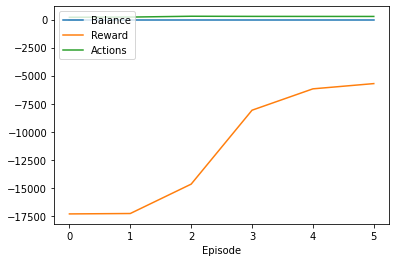

Episode 6/25 Reward: -3121.9101984193476. Balance: 0.0. Transaction Count: 278


In [246]:
tensorforce = True
episode_rewards = []
episode_transaction_count = []
episode_balances = []
highest_reward = None
highest_balance = None
highest_transaction_count = None

if tensorforce:
    env = tf_environment.open_ai_gym_env
    episode_count = 25

    for ei in range(episode_count):
        start_time = time.time()
        done = False
        states = tf_environment.reset()
        episode_reward = 0
        
        while not done:
            actions = tf_agent.act(states=states)
            states, done, reward = tf_environment.execute(actions=actions)
            tf_agent.observe(terminal=done, reward=reward)
            episode_reward += reward
            
        # First episode.
        if highest_reward == None:
            highest_reward = episode_reward
            highest_balance = env.balance
            highest_transaction_count = env.transactions.shape[0]
        else:
            highest_reward = max(highest_reward, episode_reward)
            highest_balance = max(highest_balance, env.balance)
            highest_transaction_count = max(highest_transaction_count, env.transactions.shape[0])

        end_time = time.time() - start_time
        episode_rewards.append(episode_reward)
        episode_transaction_count.append(env.transactions.shape[0])
        episode_balances.append(env.balance)
        
        visualize_episodes(episode_rewards, episode_transaction_count, episode_balances)
        print(f'Episode {ei + 1} (Time: {end_time})/{episode_count} Reward: {env.total_reward} (H. {highest_reward}). Balance: {env.balance} (H. {highest_balance}). Transaction Count: {env.transactions.shape[0]} (H. {highest_transaction_count})')

tf_environment.open_ai_gym_env.render()

##### Evaluate the Model

In [245]:
if tensorforce:
    states = tf_environment.reset()

    while not done:
        actions = tf_agent.act(states=states, independent=True)
        states, done, reward = tf_environment.execute(actions=actions)

    print(f'Evaluation Reward: {env.total_reward}. Balance: {env.balance}.')

Evaluation Reward: 0.0. Balance: 1.0.
